In [1]:
# Useful resources
# https://medium.com/analytics-vidhya/testing-multiple-machine-learning-models-at-once-without-getting-a-headache-5aefb0e7df03
# Potentially look into ensemble models

In [2]:
# In prep
import pandas as pd
import utm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

seed = 38 # Seed for train/val split

In [3]:
#Function to convert geographic to projected coordinates
def from_latlon(lat, lon):
    easting, northing, zone_num, zone_letter = utm.from_latlon(lat, lon)
    return easting, northing, zone_num, zone_letter

In [4]:
def preprocess_sim_data(sim_data, data_type, freq, tower_locs):
    # Get data
    sim_dat_filt = sim_data[sim_data['Data_type'].isin(data_type)]

    # make column with the datetime to nearest 'freq' value (e.g. 5min)
    sim_dat_filt = sim_dat_filt.assign(DateTime = sim_dat_filt['DateAndTime'].dt.floor(freq=freq))

    # group by datetime, tag, tower and antenna, compute mean power, pivot to antennas
    sim_dat_filt = (
        sim_dat_filt.groupby(['DateTime', 'TowerID', 'TagID', 'Antenna', 'POINT_X', 'POINT_Y'])['Power']
        .mean()
        .reset_index()
        .pivot_table(index=['DateTime', 'TowerID', 'TagID', 'POINT_X', 'POINT_Y'], columns='Antenna', values='Power')
        .reset_index()
        .rename(columns={1: 'ant1', 2: 'ant2', 3: 'ant3', 4: 'ant4'})
        .fillna(value=0) # Need to check the impact of this
    )
    # Calculate easting and northing from lat long
    sim_dat_filt['easting'], sim_dat_filt['northing'], sim_dat_filt['zone_num'], sim_dat_filt['zone_letter'] = from_latlon(sim_dat_filt['POINT_Y'].values, sim_dat_filt['POINT_X'].values)

    # Create a dictionary of the coordinates of the towers
    offset_dict = tower_locs.set_index('TowerID').to_dict()
    point_x = offset_dict['POINT_X']
    point_y = offset_dict['POINT_Y']

    # Standardise the coordinates so that the tower location == 0 on both the x and y axes.
    sim_dat_filt['xOffset'] = sim_dat_filt['easting'] - sim_dat_filt['TowerID'].map(point_x).fillna(0)
    sim_dat_filt['yOffset'] = sim_dat_filt['northing'] - sim_dat_filt['TowerID'].map(point_y).fillna(0)

    return sim_dat_filt

In [5]:
# Get simulation data
sim_data_path = 'H:\My Drive\Colab Notebooks\RadioTelemetry\Simul_data\Processed_RTdat_w_LatLong_append\RTdat_sim_train_20230212.xlsx'
sim_data = pd.read_excel(sim_data_path)
sim_data['DateAndTime'] = pd.to_datetime(sim_data['DateAndTime'])

# Get tower locations
radio_tower_xy_path = 'H:\My Drive\Colab Notebooks\RadioTelemetry\Tower_data\RTEastNorth.xlsx'
tower_locs = pd.read_excel(radio_tower_xy_path)


In [6]:
# Initial pass over the data using lazy predict to identify possible options
# import lazypredict
# from lazypredict.Supervised import LazyRegressor
# reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
# models, predictions = reg.fit(X_train, X_test, y_train, y_test)
# print(models)

In [7]:
# Drilling into top performing models for paramater optimisation
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor

# Create a list of test dictionaries
KNeighborsRegressor_params = [{"n_neighbors":3}, {"n_neighbors":5}, {"n_neighbors":7}]
AdaBoostRegressor_params = [{"n_estimators":25}, {"n_estimators":50}, {"n_estimators":75}]

# Create classes for the models
modelclasses = [
    ["K neighbours regressor", KNeighborsRegressor, KNeighborsRegressor_params],
    ["Ada boost regressor", AdaBoostRegressor, AdaBoostRegressor_params]
]

In [105]:
# Pre-processing parameters to test
# Variable parameters
data_type = ['Simulation'] # Simulation or Live BTF, or could do both
frequencies = ['1min', '5min']
cv = [] #To be updated

# Fixed parameters
dimensions = ['xOffset', 'yOffset']
predictors = ['ant1', 'ant2', 'ant3', 'ant4']
responses = ['xOffset', 'yOffset']
scoring = 'neg_mean_absolute_error'

trained_models = []
for dimension in dimensions:
    for freq in frequencies:
        sim_data_preproc = preprocess_sim_data(sim_data, data_type, freq, tower_locs)
        X_train = sim_data_preproc[predictors]
        y_train = sim_data_preproc[dimension] # Will need to adjust this to iterate over x and y xOffset

        # X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

        for modelname, Model, params_list in modelclasses:
            for params in params_list:
                model = Model(**params)
                scores = cross_val_score(model, X_train, y_train, cv=3, scoring=scoring)
                score = np.mean(scores)
                model.fit(X_train, y_train)
                trained_models.append((dimension, modelname, model, params, freq, score))

In [106]:
best_models = []
for dimension in dimensions:
    filtered = [x for x in trained_models if x[0] == dimension]
    filtered.sort(key=lambda x:x[-1], reverse=True)
    best_model = filtered[0]
    best_models.append(best_model)
    print(f"\nThe best performing model for {dimension} was {best_model}\n\nAll model results as follows:")

    for dimension, modelname, model, params, freq, score in filtered:
        print(dimension, modelname, params, freq, score)        


The best performing model for xOffset was ('xOffset', 'K neighbours regressor', KNeighborsRegressor(n_neighbors=7), {'n_neighbors': 7}, '5min', -330.47414811013624)

All model results as follows:
xOffset K neighbours regressor {'n_neighbors': 7} 5min -330.47414811013624
xOffset K neighbours regressor {'n_neighbors': 5} 5min -336.9463595525065
xOffset Ada boost regressor {'n_estimators': 75} 1min -345.1250773342363
xOffset Ada boost regressor {'n_estimators': 25} 5min -353.15869949310763
xOffset Ada boost regressor {'n_estimators': 50} 1min -356.0334128822478
xOffset K neighbours regressor {'n_neighbors': 3} 5min -358.0420858763479
xOffset K neighbours regressor {'n_neighbors': 7} 1min -358.6632137873644
xOffset Ada boost regressor {'n_estimators': 75} 5min -361.36467795349495
xOffset Ada boost regressor {'n_estimators': 50} 5min -365.12660504233776
xOffset Ada boost regressor {'n_estimators': 25} 1min -365.82128995410153
xOffset K neighbours regressor {'n_neighbors': 5} 1min -367.4301

In [116]:
# Pre-process test data !!!!!!!!!!!change code to reflect test data
sim_data_preproc = preprocess_sim_data(sim_data, data_type, freq, tower_locs) #### Change this to Test data

# Isolate predictor variables from test data
X_test = sim_data_preproc[predictors]

for dimension in dimensions:
    best_model = [x for x in best_models if x[0] == dimension]
    model = best_model[0][2]

    # Isolate response variable from test data
    y_test = sim_data_preproc[dimension]

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Save predictions to a new column in the test data pandas dataframe
    pred_column_name = f"{dimension}_pred"
    sim_data_preproc[pred_column_name] = y_pred

In [115]:
sim_data_preproc

Antenna,DateTime,TowerID,TagID,POINT_X,POINT_Y,ant1,ant2,ant3,ant4,easting,northing,zone_num,zone_letter,xOffset,yOffset,xOffset_pred,yOffset_pred
0,2021-03-19 07:50:00,RT01,70,146.255492,-21.919407,0.0,0.000000,0.0,84.000000,423106.337491,7.575907e+06,55,K,-232.393693,-11.475495,-497.401942,-32.265108
1,2021-03-19 07:50:00,RT04,70,146.255492,-21.919407,105.0,80.000000,0.0,0.000000,423106.337491,7.575907e+06,55,K,160.219630,233.088540,116.429167,294.862593
2,2021-03-19 07:55:00,RT01,70,146.255492,-21.919407,78.0,106.000000,34.0,0.000000,423106.337491,7.575907e+06,55,K,-232.393693,-11.475495,19.871090,4.234169
3,2021-03-19 07:55:00,RT02,70,146.255492,-21.919407,0.0,55.000000,0.0,0.000000,423106.337491,7.575907e+06,55,K,-746.125298,299.312629,-342.473875,59.422225
4,2021-03-19 07:55:00,RT03,70,146.255492,-21.919407,76.0,0.000000,0.0,0.000000,423106.337491,7.575907e+06,55,K,-282.582580,495.944163,-116.295105,349.078872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,2021-04-23 15:05:00,RT01,70,146.252698,-21.920308,0.0,78.500000,0.0,88.000000,422818.243652,7.575806e+06,55,K,-520.487532,-112.611280,-430.966631,-45.218327
512,2021-04-23 15:05:00,RT03,70,146.252698,-21.920308,66.5,0.000000,0.0,0.000000,422818.243652,7.575806e+06,55,K,-570.676419,394.808378,-196.334351,102.825429
513,2021-04-23 15:05:00,RT05,70,146.252698,-21.920308,68.0,0.000000,83.5,0.000000,422818.243652,7.575806e+06,55,K,-126.932490,-366.296196,-226.655585,-427.217776
514,2021-04-23 15:10:00,RT01,70,146.251197,-21.920565,74.0,73.666667,0.0,69.666667,422663.351956,7.575777e+06,55,K,-675.379228,-141.814731,-222.013419,27.984123


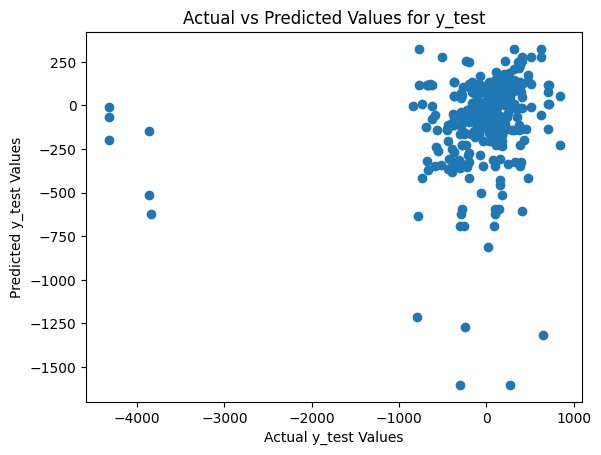

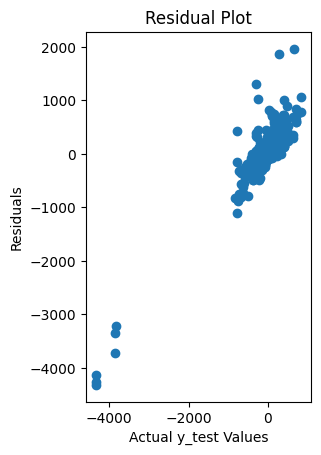

In [ ]:
# Select a model from trained_models
selected_model = trained_models[0][1]
freq = trained_models[0][3]

sim_data_preproc = preprocess_sim_data(sim_data, data_type, freq, tower_locs)
x = sim_data_preproc[predictors]
y = sim_data_preproc['xOffset'] # Will need to adjust this to iterate over x and y xOffset

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

#Fit the model on the training data
selected_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = selected_model.predict(X_test)

# Plot the estimated vs actual predictions
plt.scatter(y_test, y_pred)
plt.xlabel("Actual y_test Values")
plt.ylabel("Predicted y_test Values")
plt.title("Actual vs Predicted Values for y_test")
plt.show()

# Plot the residuals
residuals = y_test - y_pred
plt.subplot(1, 2, 2)
plt.scatter(y_test, residuals)
plt.xlabel("Actual y_test Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [ ]:
len(y_pred)

320

In [ ]:
sim_data_preproc

Antenna,DateTime,TowerID,TagID,POINT_X,POINT_Y,ant1,ant2,ant3,ant4,easting,northing,zone_num,zone_letter,xOffset,yOffset
0,2021-03-19 07:54:00,RT01,70,146.255492,-21.919407,0.0,0.0,0.0,84.0,423106.337491,7.575907e+06,55,K,-232.393693,-11.475495
1,2021-03-19 07:54:00,RT04,70,146.255492,-21.919407,105.0,80.0,0.0,0.0,423106.337491,7.575907e+06,55,K,160.219630,233.088540
2,2021-03-19 07:55:00,RT03,70,146.255492,-21.919407,70.0,0.0,0.0,0.0,423106.337491,7.575907e+06,55,K,-282.582580,495.944163
3,2021-03-19 07:55:00,RT05,70,146.255492,-21.919407,0.0,0.0,85.5,0.0,423106.337491,7.575907e+06,55,K,161.161349,-265.160411
4,2021-03-19 07:55:00,RT07,70,146.255492,-21.919407,0.0,67.0,0.0,0.0,423106.337491,7.575907e+06,55,K,-680.791419,-224.583856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,2021-04-23 15:09:00,RT03,70,146.252698,-21.920308,66.0,0.0,0.0,0.0,422818.243652,7.575806e+06,55,K,-570.676419,394.808378
1061,2021-04-23 15:11:00,RT01,70,146.251197,-21.920565,0.0,76.0,0.0,85.0,422663.351956,7.575777e+06,55,K,-675.379228,-141.814731
1062,2021-04-23 15:11:00,RT05,70,146.251197,-21.920565,14.0,0.0,0.0,0.0,422663.351956,7.575777e+06,55,K,-281.824186,-395.499647
1063,2021-04-23 15:12:00,RT01,70,146.251197,-21.920565,0.0,74.0,0.0,29.0,422663.351956,7.575777e+06,55,K,-675.379228,-141.814731


Superseded

In [ ]:
insights = []
for freq in frequencies:
    sim_data_preproc = preprocess_sim_data(sim_data, data_type, freq, tower_locs)
    x = sim_data_preproc[predictors]
    y = sim_data_preproc['xOffset'] # Will need to adjust this to iterate over x and y xOffset

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

    for modelname, Model, params_list in modelclasses:
        for params in params_list:
            model = Model(**params)
            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            insights.append((modelname, model, params, freq, score))